# Finance-Python
---------------------------------

> 原始项目地址：**Finance-Python**（https://github.com/wegamekinglc/Finance-Python）；

> * ``python setup.py install`` 或者,
> * ``pip install finance-python``

> 相关依赖请见主目录下 ``requirements`` 文件夹。

## Operator in Declarative Style
----------------------------------------------

### 声明式

计算表达式被抽象为一些**算子**，用户无需给出计算的流程，只需要使用这些**算子**表达自己的想法。

例如，我们需要计算向量 $\bar x$ 的均值，**命令式**的做法可能如下：

```python
sum_value = 0
for v in x:
   sum_value += v 
average_value = sum_value / len(x)
```

而**声明式**的做法：

```python
average_value = mean(x)
```

上面的 ``mean`` 就是我们所谓的算子概念。

### 延迟计算


表达式无需在定义的位置获得结果，只需在需要的时候进行计算即可：

```python

expression = operator(dependency)

```

中间会有一些其他计算的代码：

```
......
```

这里的 ``expression`` 是一个表达式对象，而不是计算的结果，在需要值的时候：

```python

expression_value = expression.value

```

### 支持算术运算

表达式对象支持基本的 ``+-*/`` 运算。

例如，计算收益率的sharp值，我们可以这样去定义表达式：

```python

sharp_expression = mean(x) / std(x)

```

这里的 ``sharp_expression`` 是一个新的表达式，由两个基础的表达式构造而成。

### 支持复合运算

运算可以复合，例如实现以下的逻辑，计算过去20日每日50日均线的标准差：

```python

compounded_expression = std(mean(x, 50), 20)

```

## Implementation in Finance-Python

在 **Finance-Python** 中，以 **accumulator** 的形式实现了上面的 **Declarative Style Operator**。**accumulator** 是具有自身状态的算符，

## Accumulator

### Hello World

下面的这个例子，使用 ``Latest`` 算符，保留输入值的最近状态。

In [18]:
from PyFin.Math.Accumulators import Latest

exp1 = Latest('x')
exp1

上面可以看到 ```exp1``` 是一个 ``accumulator`` 的实例。

In [19]:
# 1st round
exp1.push({'x': 1})
print("Value after 1st round: {0}".format(exp1.value))

# 2nd round
exp1.push({'x': 2})
print("Value after 2nd round: {0}".format(exp1.value))

# repeate
print("Do nothing: {0}".format(exp1.value))

# 3rd and 4th round
exp1.push({'x': 3})
exp1.push({'x': 4})
print("Value after 3rd/4th round: {0}".format(exp1.value))

Value after 1st round: 1.0
Value after 2nd round: 2.0
Do nothing: 2.0
Value after 3rd/4th round: 4.0


### One Step Further

下面的例子，计算过去两个输入值的均值：

In [20]:
from PyFin.Math.Accumulators import MovingAverage

ma = MovingAverage(x='x', window=2)

values = [1, 2, 3, 4, 5]

for i, x in enumerate(values):
    ma.push({'x': x})
    print("{0}: {1}".format(i, ma.value))

0: 1.0
1: 1.5
2: 2.5
3: 3.5
4: 4.5


### More complicated examples

#### 算术运算/复合运算

计算一组收益率序列的滚动sharp，时间窗口为250日。

构造算子：

In [21]:
import numpy as np
from PyFin.Math.Accumulators import MovingVariance
from PyFin.Math.Accumulators import Sqrt

np.random.seed(47)
ret_simulated = 0.0005 + np.random.randn(2000) / 100.

ret_mean = MovingAverage(x='x', window=250)
ret_std = Sqrt(MovingVariance(x='x', window=250)) # Compounded accumlator is used here

sharp = ret_mean / ret_std # dividing can be used for accumulators
sharp

输入数据：

In [22]:
sharp_series = []
for ret in ret_simulated:
    sharp.push({'x': ret})
    sharp_series.append(sharp.value)

把数据画出来出来：

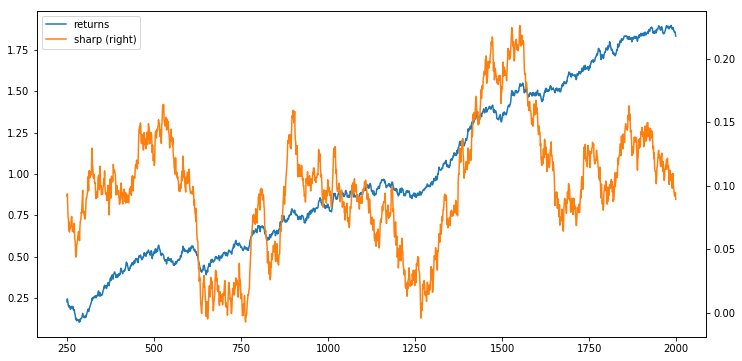

In [23]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame({'returns': ret_simulated.cumsum(), 'sharp': sharp_series})
df[250:].plot(secondary_y='sharp', figsize=(12, 6))

#### 复合运算

下面的例子中，我们计算一组序列，20日均线和50日均线的250日相关系数：

In [24]:
from PyFin.Math.Accumulators import MovingCorrelation

ma20 = MovingAverage(x='x', window=20)
ma50 = MovingAverage(x='x', window=50)

corr = MovingCorrelation(window=250, x=ma20, y=ma50)
corr

In [25]:
ma20_series = []
ma50_series = []
corr_series = []
for ret in ret_simulated:
    ma20.push({'x': ret})
    ma50.push({'x': ret})
    corr.push({'x': ret})
    
    ma20_series.append(ma20.value)
    ma50_series.append(ma50.value)
    corr_series.append(corr.value)

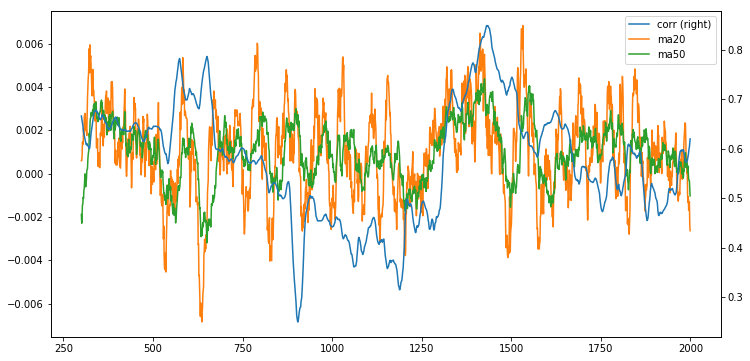

In [26]:
df = pd.DataFrame({'ma20': ma20_series, 'ma50': ma50_series, 'corr': corr_series})
df[300:].plot(secondary_y='corr', figsize=(12, 6))

### Working with Pandas

In [27]:
from PyFin.api import MA
from PyFin.examples.datas import sample_data

In [28]:
sample_data

,code,open,close
2016-01-01,1,2.0,1.7
2016-01-01,2,1.0,1.6
2016-01-02,1,1.5,0.9
2016-01-02,2,3.0,3.8
2016-01-03,1,2.4,1.6
2016-01-03,2,3.5,2.1


In [29]:
ma2 = MA(2, 'close')

#### 根据 ``category_field`` 计算

In [30]:
ma2.transform(sample_data, category_field='code')

,transformed,code
2016-01-01,1.70,1
2016-01-01,1.60,2
2016-01-02,1.30,1
2016-01-02,2.70,2
2016-01-03,1.25,1
2016-01-03,2.95,2


#### 直接计算

In [31]:
ma2 = MA(2, 'close')

In [32]:
ma2.transform(sample_data)

,transformed
2016-01-01,1.70
2016-01-01,1.65
2016-01-02,1.25
2016-01-02,2.35
2016-01-03,2.70
2016-01-03,1.85
